# 1 Entendimiento de datos/negocio

#### Integrantes

Juan Esteban Quiroga - 202013216 (j.quirogar@uniandes.edu.co)

Andres Ortiz - 201727662 (a.ortizg@uniandes.edu.co)

Carlos Diaz - 202210262 (c.diazv@uniandes.edu.co)

-----


**Context:** 

FutAlpes F.C., a club in one of Europe’s top five leagues, aims to strengthen its squad in the 2025 transfer market. The club has a budget of €100M and wants to sign 1 player per zone (goalkeeper, defender, midfielder, forward). The transfer market is highly competitive, with historically high player prices.

**Current Problem:**

Player valuations are often based on intuition or experience of agents and scouts. This creates uncertainty and financial risk in investments.

**Proposal:**

Build a machine learning model to predict a player’s market value based on performance statistics.
Include both traditional metrics (goals, assists, passes, duels) and advanced ones (xG, npxG, xA, PSxG).
Assess data quality and representativeness to ensure a solid foundation for the model.

**Expected Value:**
- Reduce uncertainty in transfer negotiations.
- Identify players offering the best performance-to-price ratio.
- Maximize return on investment while reinforcing the squad within budget.

⚠️ Usar <=Python3.11

## 1.1 Carga de datos

In [1]:
import numpy as np
import pandas as pd
import re

%matplotlib inline


In [2]:
db_location = 'data/datos_entrenamiento_laboratorio1(train_data).csv'

In [3]:
football_df=pd.read_csv(db_location, sep=',', encoding = "UTF-8-SIG")

In [4]:
football_df.shape

(57934, 50)

### 1.1.1 Eliminación de columnas duplicadas

Las siguientes columnas estaban duplicadas entonces las eliminamos del dataframe.

In [5]:
dupe_cols = [
    "xAG.1",
    "Pases_intentados.1",
    "Pases_intentados.2",
    "Pases_progresivos.1",
    "Regates_exitosos.1",
    "xAG.2",
    "xAG.3",
    "Pases_completados.1",
    "Pases_completados.2",
]

football_df_slim = football_df.drop(columns=dupe_cols, errors="raise")
football_df_slim.shape

(57934, 41)

In [6]:
print(football_df_slim.sample(10).to_string())

                    Jugador Nacionalidad Posicion    Edad                  Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
16757           Abdel Abqar       ma MAR       CB  25-265   Saturday November 30, 2024      0              0  0.0   0.0  0.1                         3                50                 12                 0                        23               

### 1.1.2 Analisis de tipos de datos

In [7]:
!pip install ydata-profiling
!pip install ipywidgets

In [8]:
# import pandas_profiling

# profiling = pandas_profiling.ProfileReport(football_df_slim)
# profiling.to_file("football_profile.html")

In [9]:
football_df_slim.dtypes

Jugador                            object
Nacionalidad                       object
Posicion                           object
Edad                               object
Dia_partido                        object
Goles                               int64
Tiros Totales                       int64
xG                                float64
npxG                              float64
xAG                               float64
Acciones_que_crean_tiros            int64
Pases_intentados                    int64
Pases_progresivos                   int64
Regates_exitosos                    int64
Pases_medios_completados            int64
Pases_largos_completados            int64
xA                                float64
Pases_en_ultimo_tercio              int64
Pases_balon_vivo                    int64
Pases_balon_muerto                  int64
Pases_al_hueco                      int64
Pases_centros                       int64
Pases_completados                   int64
Pases_fuera_de_juego              

In [10]:
# Analisis de la variable "Jugador"
num_players = football_df_slim["Jugador"].nunique()
print("Total distinct players:", num_players)

Total distinct players: 2242


In [11]:
# Fuzzy search para encontrar nombres parecidos
!pip install rapidfuzz
from rapidfuzz import fuzz

unique_names = football_df["Jugador"].unique()

possible_dupes = []
for i, name in enumerate(unique_names):
    for other in unique_names[i+1:]:
        score = fuzz.ratio(name, other)
        if score > 88.5:  
            possible_dupes.append((name, other, score))

for name1, name2, score in possible_dupes:
    print(f"{name1}  <--->  {name2}   (similarity: {score}%)")

Neco Williams  <--->  Nico Williams   (similarity: 92.3076923076923%)
Valentin Rosier  <--->  Valentin Rongier   (similarity: 90.32258064516128%)
Sergio Gomez  <--->  Sergi Gomez   (similarity: 95.65217391304348%)
Dani Rodriguez  <--->  Daniel Rodriguez   (similarity: 93.33333333333333%)
Pablo Marin  <--->  Pablo Mari   (similarity: 95.23809523809523%)
Jon Martin  <--->  Jonas Martin   (similarity: 90.9090909090909%)
Ismael Konate  <--->  Ismael Kone   (similarity: 91.66666666666666%)


In [12]:
# Analisis de la variable "Nacionalidad"
print(football_df_slim["Nacionalidad"].value_counts().to_string())

Nacionalidad
fr FRA     9351
es ESP     8951
it ITA     4436
eng ENG    4430
br BRA     2251
ar ARG     1783
pt POR     1631
nl NED     1479
ci CIV     1417
sn SEN     1226
ma MAR     1120
be BEL      968
dk DEN      818
ng NGA      770
se SWE      762
dz ALG      687
ch SUI      673
gh GHA      668
ml MLI      624
rs SRB      618
de GER      597
cm CMR      588
no NOR      576
hr CRO      558
jp JPN      556
co COL      519
pl POL      497
us USA      469
uy URU      452
sct SCO     435
ie IRL      355
ca CAN      334
wls WAL     281
gn GUI      257
ao ANG      252
ge GEO      244
ua UKR      234
al ALB      219
eg EGY      207
cd COD      204
ro ROU      200
sk SVK      193
tr TUR      192
hu HUN      182
ec ECU      182
ga GAB      171
at AUT      166
is ISL      165
si SVN      154
ve VEN      149
gr GRE      147
cz CZE      144
tn TUN      143
xk KVX      137
mx MEX      133
py PAR      132
ru RUS      123
kr KOR      121
cl CHI      115
tg TOG      115
gw GNB      107
cg CGO     

In [13]:
# Analisis de la variable "Posicion"
print(football_df_slim["Posicion"].value_counts().to_string())

Posicion
CB                9537
FW                6858
CM                5763
GK                3987
DM                3729
RB                3265
LB                3244
AM                3236
LW                2703
RW                2638
WB                1903
LM                1654
RM                1629
DM,CM              529
CM,DM              376
LW,RW              221
AM,FW              211
FW,AM              190
LW,LM              175
RW,LW              160
AM,CM              157
RW,RM              147
RB,CB              141
LM,CM              131
AM,LW              128
CB,RB              127
LW,AM              125
FW,LW              118
RM,CM              118
RW,FW              115
LW,FW              115
CM,RM              112
AM,DM              111
CM,AM              109
FW,RW              108
WB,LB              107
CM,LM              105
RM,RW              105
AM,RW              103
RM,LM              102
LM,RM               98
DM,AM               95
CB,LB               92
WB

In [14]:
# Analisis de variable "Edad" (e.g 20-034, 24-122)
mask = football_df_slim["Edad"].astype(str).str.startswith("20")
subset = football_df_slim.loc[mask, "Edad"]

suffix = subset.str.split("-").str[1].astype(int)
print("Min suffix:", suffix.min())
print("Max suffix:", suffix.max())

Min suffix: 0
Max suffix: 365


In [15]:
# Analisis de variable "Goles"
goles = football_df_slim["Goles"]
print("Min goles:", goles.min())
print("Max goles:", goles.max())

goles.value_counts()
football_df_slim = football_df_slim.sort_values(by="Goles", ascending=False)
print(
    football_df_slim.loc[
        football_df_slim["Goles"] > 5, ["Jugador", "Goles"]
    ].to_string()
)

Min goles: -5
Max goles: 995
                     Jugador  Goles
27143          Sergi Roberto    995
42430          Jaydee Canvot    955
33118     Henrikh Mkhitaryan    910
45061            Desire Doue    887
7706           Neco Williams    871
32240              Saul Coco    862
37399        Amir Richardson    861
36984         Pietro Comuzzo    838
4086         Nicolas Jackson    807
26484         Stefan de Vrij    795
41484           Steve Ngoura    792
12403        Victor Meseguer    689
19962             Kike Salas    663
54110              Junya Ito    663
27555              Isak Hien    663
53488        Lilian Raolisoa    633
47821        Abdoulaye Toure    632
18111        Jorge de Frutos    594
36477     Rolando Mandragora    590
16916  Isaac Palazon Camacho    557
52808        Jonathan Gradit    537
4948          Bernardo Silva    528
10901       Antonee Robinson    509
26396         Marten de Roon    507
5784                   Andre    505
1856                Casemiro    485

In [16]:
# Analisis de variable "Tiros totales"
tiros_totales = football_df_slim["Tiros Totales"]
print("Min Tiros Totales:", tiros_totales.min())
print("Max Tiros Totales:", tiros_totales.max())
print("Mean Tiros Totales:", tiros_totales.mean())

Min Tiros Totales: 0
Max Tiros Totales: 12
Mean Tiros Totales: 0.7924016984844824


In [17]:
# Analisis de variable "xG"
xG = football_df_slim["xG"]
print("Min xG:", xG.min())
print("Max xG:", xG.max())
print("Mean xG:", xG.mean())

Min xG: 0.0
Max xG: 2.9
Mean xG: 0.08863534366693135


In [18]:
# Analisis de variable "market_value"
# See how many distinct market values each player has
# Group and collect the unique values as a Python list
market_values_per_player = (
    football_df_slim.groupby("Jugador")["market_value"]
    .apply(lambda x: list(set(x)))
    .reset_index()
)

print(market_values_per_player.to_string())

                             Jugador                      market_value
0              Aaron Ciammaglichella                           [€700k]
1                    Aaron Cresswell                             [nan]
2                      Aaron Malouda                             [nan]
3                       Aaron Martin                          [€6.50m]
4                     Aaron Ramsdale                [€10.00m, €16.00m]
5                   Aaron WanBissaka                         [€24.00m]
6                       Abakar Sylla                         [€10.00m]
7                      Abdallah Sima                          [€9.00m]
8                    Abde Ezzalzouli                         [€12.00m]
9                        Abdel Abqar                          [€7.50m]
10               Abderrahman Rebbach                           [€700k]
11                       Abdon Prats                          [€1.20m]
12                     Abdou Harroui                          [€1.80m]
13    

In [19]:

total_players_multiple_mv = (
    football_df.groupby("Jugador")["market_value"]
    .nunique()
    .gt(1)  # True if >1
    .sum()  # count how many True
)

print(f"# de jugadores con más de un market value: {total_players_multiple_mv}")

# de jugadores con más de un market value: 174


Teniendo en cuenta los valores y los tipos de datos del dataframe, hallamos estas observaciones en el esquema de datos:
- **Jugador** se representa como ```object``` ("Bruno Fernandes") pero debería ser de tipo ```StringDtype``` ya que es texto puro. (Algunos de estos nombres podrían representar el mismo jugador pero con errores)

- **Nacionalidad** se representa como ```object``` ("eng ENG") pero debería ser de tipo ```StringDtype``` ya que es texto puro pero toca transformarlo para que solo sea "ENG".

- **Posicion** se representa como ```object``` ("DM,AM") pero debería ser transformado en algún tipo de encoder ya que cada jugador puede tener mas de una posición en un mismo partido. (Un candidato puede ser *One-Hot Encoding* de posiciones por partido para luego trasformarlo en datos más significativos).

- **Edad** se representa como ```object``` ("33-209") bajo la nomenclatura de "años-días" para cada partido. Debe ser consolidada en una sola edad tomando la edad máxima en el data set y convietiendola a ```float32```.

- **Dia_partido** se representa como ```object``` ("Friday August 16, 2024") pero debería ser de tipo ```Timestamp```.

- **market_value** se representa como ```object``` ("€50.00m") pero debería ser de tipo ```float32```. Esta variable tiene 174 jugadores que tienen más de un **market_value**. Sin embargo, hay ~2000 jugadores unicos lo cual indica que esta variable debería guardar el valor más reciente en el tiempo para cada jugador.

- **contract_date** se representa como ```object``` ("30.06.2028") pero debería ser de tipo ```Timestamp```.


## 1.2 Consideraciones de negocio

(Aca van descripciones de temas relevantes al negocio)

# 2. Preparación de datos

In [20]:
print(football_df_slim.head(10).to_string())

                  Jugador Nacionalidad Posicion    Edad                  Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
27143       Sergi Roberto       es ESP       DM  32-255    Saturday October 19, 2024    995              0  0.0   0.0  0.0                         1                64                  8                 1                        17                   

## 2.1 Eliminación de filas duplicadas (Pt 1)
Ahora, queremos eliminar los registros de jugadores con valores identicos. Estos son duplicados inecesarios.

In [21]:
# 1. Ver cantidad de jugadores únicos
print("Jugadores distintos:", football_df_slim["Jugador"].nunique())

Jugadores distintos: 2242


Anteriormente vimos que estos jugadores tenian similitud > 88.5% en el nombre

```
Neco Williams  <--->  Nico Williams   (similarity: 92.3076923076923%)
Valentin Rosier  <--->  Valentin Rongier   (similarity: 90.32258064516128%)
Sergio Gomez  <--->  Sergi Gomez   (similarity: 95.65217391304348%)
Dani Rodriguez  <--->  Daniel Rodriguez   (similarity: 93.33333333333333%)
Pablo Marin  <--->  Pablo Mari   (similarity: 95.23809523809523%)
Jon Martin  <--->  Jonas Martin   (similarity: 90.9090909090909%)
Ismael Konate  <--->  Ismael Kone   (similarity: 91.66666666666666%)
```


In [22]:
pairs = [
    ("Neco Williams", "Nico Williams"),
    ("Valentin Rosier", "Valentin Rongier"),
    ("Sergio Gomez", "Sergi Gomez"),
    ("Dani Rodriguez", "Daniel Rodriguez"),
    ("Pablo Marin", "Pablo Mari"),
    ("Jon Martin", "Jonas Martin"),
    ("Ismael Konate", "Ismael Kone"),
]

for p1, p2 in pairs:
    print(f"\n=== {p1}  <->  {p2} ===")
    subset = football_df_slim[
        football_df_slim["Jugador"].str.lower().isin([p1.lower(), p2.lower()])
    ][["Jugador", "Edad", "Nacionalidad"]]

    print(subset.drop_duplicates().sort_values("Jugador").to_string(index=False))


=== Neco Williams  <->  Nico Williams ===
      Jugador   Edad Nacionalidad
Neco Williams 23-308      wls WAL
Neco Williams 24-008      wls WAL
Neco Williams 24-018      wls WAL
Neco Williams 24-022      wls WAL
Neco Williams 24-028      wls WAL
Neco Williams 24-035      wls WAL
Neco Williams 24-042      wls WAL
Neco Williams 23-133      wls WAL
Neco Williams 23-364      wls WAL
Neco Williams 23-231      wls WAL
Neco Williams 23-195      wls WAL
Neco Williams 23-191      wls WAL
Neco Williams 23-176      wls WAL
Neco Williams 23-168      wls WAL
Neco Williams 23-162      wls WAL
Neco Williams 23-154      wls WAL
Neco Williams 23-140      wls WAL
Neco Williams 23-224      wls WAL
Neco Williams 23-357      wls WAL
Neco Williams 23-126      wls WAL
Neco Williams 23-336      wls WAL
Neco Williams 23-252      wls WAL
Neco Williams 23-245      wls WAL
Neco Williams 23-294      wls WAL
Neco Williams 23-353      wls WAL
Neco Williams 23-260      wls WAL
Neco Williams 23-238      wls WAL
Neco 

Después de hacer validaciones comparando edad y nacionalidad con ayuda de un motro de busqueda, se puede verificar que ningún jugador está realmente presente bajo dos nombres diferentes. Sin embargo, hay un jugador "Dani Rodriguez" que solo tiene un registro en el dataset. Se puede considerar eliminar.

In [23]:
# True duplicates: entire row identical
true_dupes = football_df_slim[football_df_slim.duplicated(keep=False)]

print("Numero de true duplicates:", true_dupes.shape[0])

Numero de true duplicates: 20966


In [24]:
before = football_df_slim.shape[0]
football_df_slim = football_df_slim.drop_duplicates(keep="first")
after = football_df_slim.shape[0]

print(f"Filas antes: {before}\nFilas después: {after}\nFilas eliminadas: {before - after}")

Filas antes: 57934
Filas después: 47451
Filas eliminadas: 10483


Después de eliminar las filas perfectamente duplicadas, ahora identificamos filas en las que el jugador tiene dos o mas registros en la misma fecha.

In [25]:
# Filtrar duplicados por Jugador + Dia_partido
dupes = football_df_slim[
    football_df_slim.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]

# Ordenar por jugador y fecha
dupes = dupes.sort_values(["Jugador", "Dia_partido"]).reset_index(drop=True)

print(f"Total de duplicados en Jugador y Dia_partido: {len(dupes)}")

Total de duplicados en Jugador y Dia_partido: 5229


Al mirar los datos, nos dimos cuenta que entre estas 5229 filas que comparted el mismo **Jugador** y **Dia_partido**, hay algunos que son identicos excepto por el valor de **Market_value**. El siguiente snippet busca los duplicados excluyendo la columna **Market_value**:

In [26]:
# Subset of columns to check (exclude market_value)
cols_to_check = [c for c in football_df_slim.columns if c != "market_value"]

# From your subset of dupes (same Jugador+Dia_partido)
exact_dupes_ignoring_mv = dupes[dupes.duplicated(subset=cols_to_check, keep=False)]

print("Duplicados exactos ignorando market_value:", exact_dupes_ignoring_mv.shape[0])

Duplicados exactos ignorando market_value: 1430


In [27]:
# Sacar jugadores y conflictos de market_value
multi_values = exact_dupes_ignoring_mv.groupby(["Jugador", "Dia_partido"])[
    "market_value"
].nunique()
# Each (Jugador, Dia_partido) with more than 1 unique value
conflicts = multi_values[multi_values > 1]

# Total number of conflicting values (all market_value entries in those dates)
total_conflicts = (
    exact_dupes_ignoring_mv.set_index(["Jugador", "Dia_partido"])
    .loc[conflicts.index]  # select only the conflicted (Jugador, Dia_partido)
    .shape[0]
)

# Number of "removable" rows (beyond the 1 you'd keep per date)
removable_rows = total_conflicts - len(conflicts)

print("Total conflicting rows:", total_conflicts)
print("Of which (to remove):", removable_rows)

Total conflicting rows: 1430
Of which (to remove): 735


Para eliminar estas filas duplicadas en **Jugador** y **Dia_partido**,toca preservar la fila con mayor valor de mercado para tener el más alto en esa fecha siendo optimistas. Sin embargo, para lograr esto toca limpiar el formato de los datos de **market_value** para que sea un número en millones de euros.

## 2.2 Transformación de datos en **market_value**

In [28]:
# Explorar formato de datos
distinct_market_values_raw = football_df_slim["market_value"].unique()

print("Distinct market values (raw):")
print(distinct_market_values_raw)

Distinct market values (raw):
['€9999.99m' 'error' '€25.00m' nan '€120.00m' '€30.00m' '€90.00m'
 '€180.00m' '€10.00m' '€22.00m' '€28.00m' '€45.00m' '€35.00m' '-'
 '€40.00m' '€50.00m' '€75.00m' '€3.00m' '€5.00m' '€60.00m' '€12.00m'
 '€20.00m' '€170.00m' '€42.00m' '€14.00m' '€2.50m' '€6.00m' '€1.50m'
 '€18.00m' '€3.50m' '€15.00m' '€4.00m' '€100.00m' '€70.00m' '€32.00m'
 '€4.50m' '€9.00m' '€7.00m' '€200.00m' '€8.00m' '€1.70m' '€95.00m'
 '€24.00m' '€55.00m' '€8.50m' '€1.00m' '€16.00m' '€150k' '€80.00m' '€800k'
 '€65.00m' '€11.00m' '€2.00m' '€1.80m' '€300k' '€2.80m' '€1.20m' '€38.00m'
 '€900k' '€100k' '€17.00m' '€700k' '€5.50m' '€1.60m' '€13.00m' '€150.00m'
 '€3.60m' '€26.00m' '€7.50m' '€2.20m' '€400k' '€1.30m' '€850k' '€3.40m'
 '€350k' '€23.00m' '€500k' '€130.00m' '€140.00m' '€200k' '€85.00m' '€750k'
 '€600k' '€27.00m' '€6.50m' '€450k' '€110.00m' '€1.40m' '€2.40m' '€3.20m'
 '€250k' '€4.30m' '€550k' '€650k' '€50k' '€1000.00m']


Al ver estos datos, podemos afirmar que filas con **market_value** de ```NaN```, ```-```, o ```error``` deben ser eliminadas ya que no van a poder contribuir al análisis de mercado.

In [29]:
# Eliminar filas con 'NaN', 'error', o '-' de market_value
football_df_slim_cleaned = football_df_slim[
    ~football_df_slim['market_value'].isin(['error', '-', np.nan])
]

print(f"Tamano original: {len(football_df_slim)}")
print(f"Tamano limpio: {len(football_df_slim_cleaned)}")
print(f"Filas eliminadas : {len(football_df_slim) - len(football_df_slim_cleaned)}")


Tamano original: 47451
Tamano limpio: 37234
Filas eliminadas : 10217


In [30]:
import numpy as np


# Function to clean market_value and convert to millions of euros
def clean_market_value(value):
    if isinstance(value, str):
        # Remove currency symbols and commas
        value = value.replace("€", "").replace(",", "").strip()

        # Handle 'k' for thousands (convert to millions)
        if "k" in value:
            return float(value.replace("k", "")) / 1000  # Convert to millions
        # Handle 'm' for millions
        elif "m" in value:
            return float(value.replace("m", ""))  # Already in millions
    try:
        # If it's already a number, return it in millions
        return float(value) / 1000000  # Convert to millions (if needed)
    except ValueError:
        # Return NaN if the value is invalid
        return np.nan


# Apply the cleaning function to the 'market_value' column using .loc to avoid the warning
football_df_slim_cleaned.loc[:, "market_value"] = football_df_slim_cleaned[
    "market_value"
].apply(clean_market_value)

# Now let's check how many rows were removed and how many are left
print(f"Original dataset size: {len(football_df_slim)}")
print(f"Cleaned dataset size : {len(football_df_slim_cleaned)}")
print(f"Rows removed         : {len(football_df_slim) - len(football_df_slim_cleaned)}")

Original dataset size: 47451
Cleaned dataset size : 37234
Rows removed         : 10217


Verificamos que la transformación se logró correctamente:

In [31]:
# Explorar formato de datos
distinct_market_values_raw = football_df_slim_cleaned["market_value"].unique()

print("Distinct market values (raw):")
print(distinct_market_values_raw)

Distinct market values (raw):
[9999.99 25.0 120.0 30.0 90.0 180.0 10.0 22.0 28.0 45.0 35.0 40.0 50.0
 75.0 3.0 5.0 60.0 12.0 20.0 170.0 42.0 14.0 2.5 6.0 1.5 18.0 3.5 15.0 4.0
 100.0 70.0 32.0 4.5 9.0 7.0 200.0 8.0 1.7 95.0 24.0 55.0 8.5 1.0 16.0
 0.15 80.0 0.8 65.0 11.0 2.0 1.8 0.3 2.8 1.2 38.0 0.9 0.1 17.0 0.7 5.5 1.6
 13.0 150.0 3.6 26.0 7.5 2.2 0.4 1.3 0.85 3.4 0.35 23.0 0.5 130.0 140.0
 0.2 85.0 0.75 0.6 27.0 6.5 0.45 110.0 1.4 2.4 3.2 0.25 4.3 0.55 0.65 0.05
 1000.0]


Aprovechamos para inspeccionar los outliers en market_value:

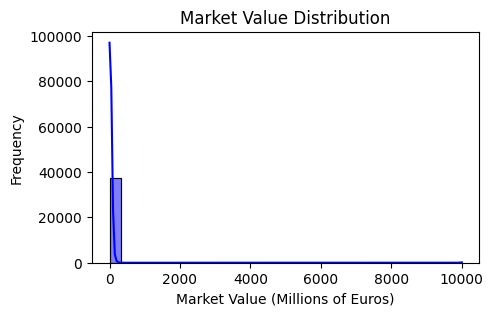

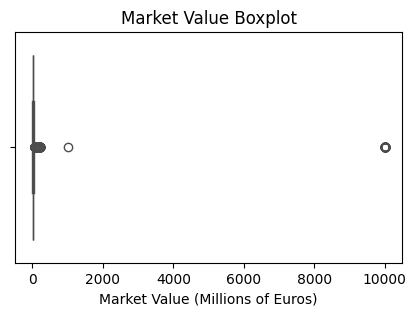

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# 1. Histogram
plt.figure(figsize=(5, 3))
sns.histplot(football_df_slim_cleaned["market_value"], kde=True, color="blue", bins=30)
plt.title("Market Value Distribution")
plt.xlabel("Market Value (Millions of Euros)")
plt.ylabel("Frequency")
plt.show()

# 2. Boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(x=football_df_slim_cleaned["market_value"], color="orange")
plt.title("Market Value Boxplot")
plt.xlabel("Market Value (Millions of Euros)")
plt.show()




In [33]:
# Sort by market_value in descending order and get the top 20 players
top_100_players = (
    football_df_slim_cleaned[["Jugador", "market_value"]]
    .sort_values(by="market_value", ascending=False)
    .head(100)
)

# Display the top 20 players
print(top_100_players.to_string(index=False))

              Jugador market_value
        Sergi Roberto      9999.99
        Daniel Vivian      9999.99
       Ibrahima Niane      9999.99
    Dylan Batubinsika      9999.99
        Shavy Babicka      9999.99
        Lucas Paqueta      9999.99
         Falaye Sacko      9999.99
        Juan Cuadrado      9999.99
     Mikkel Damsgaard      9999.99
       Antoine Joujou      9999.99
        Ivan Provedel      9999.99
         James Garner      9999.99
     Łukasz Skorupski      9999.99
         Clinton Mata      9999.99
         Obite NDicka      9999.99
Jose Luis Garcia Vaya      9999.99
       NgalAyel Mukau      9999.99
         Benat Prados      9999.99
       Nathan Collins      9999.99
          Mattia Bani      9999.99
       Kembo Diliwidi      9999.99
         Mahdi Camara      9999.99
      Marcus Rashford      9999.99
    Noussair Mazraoui      9999.99
   Andrew Omobamidele      9999.99
     Corentin Tolisso      9999.99
      Tanner Tessmann      9999.99
                Andr

Verificando en la página web de ```Transfermarkt```, el jugador más valioso del mundo es Lamine Yamal. Asi que todas las filas con **market_value** > 200M se descartan.

In [34]:
# borrar filas 
football_df_slim_cleaned = football_df_slim_cleaned[football_df_slim_cleaned['market_value'] <= 200.0]

# Confirm the size of the DataFrame after removal
print(f"Dataset size after deletion: {len(football_df_slim_cleaned)}")


Dataset size after deletion: 37182


Confirmamos que solo hay valores reales

In [35]:
# Agrupar por jugador y obtener el valor máximo de mercado para cada jugador
max_market_value_per_player = (
    football_df_slim_cleaned.groupby("Jugador")["market_value"].max().reset_index()
)

# Ordernar por valor de mercado en orden descendente para ver los jugadores con mayor valor de mercado
max_market_value_per_player_sorted = max_market_value_per_player.sort_values(
    by="market_value", ascending=False
)

print(max_market_value_per_player_sorted.head(10).to_string(index=False))

          Jugador market_value
     Lamine Yamal        200.0
  Jude Bellingham        180.0
   Erling Haaland        180.0
    Kylian Mbappe        180.0
  Vinicius Junior        170.0
      Bukayo Saka        150.0
            Pedri        140.0
Federico Valverde        130.0
      Declan Rice        120.0
      Cole Palmer        120.0


In [36]:
print(football_df_slim.head(10).to_string())

                  Jugador Nacionalidad Posicion    Edad                  Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
27143       Sergi Roberto       es ESP       DM  32-255    Saturday October 19, 2024    995              0  0.0   0.0  0.0                         1                64                  8                 1                        17                   

## 2.3 Transformación de datos en **Dia_partido**

Las fechas en esta columna están así "Saturday October 19, 2024". Toca transformar a datetime.

In [37]:
# Get unique values in the 'Dia_partido' column
unique_dia_partido = football_df_slim_cleaned["Dia_partido"].unique()

# Print each unique 'Dia_partido' value on a new line
for date in unique_dia_partido:
    print(date)

Saturday May 10, 2025
Saturday September 28, 2024
Friday February 28, 2025
Saturday February 1, 2025
Saturday August 24, 2024
Saturday November 30, 2024
Saturday January 25, 2025
Saturday February 15, 2025
Saturday January 18, 2025
Thursday January 16, 2025
Sunday April 27, 2025
Saturday August 31, 2024
Sunday November 10, 2024
Saturday October 5, 2024
Sunday August 25, 2024
Saturday December 21, 2024
Sunday May 25, 2025
Sunday May 11, 2025
Saturday September 14, 2024
Saturday April 19, 2025
Saturday February 8, 2025
Sunday October 6, 2024
Sunday December 22, 2024
Saturday November 9, 2024
Saturday October 26, 2024
Saturday November 23, 2024
Sunday November 3, 2024
Friday October 25, 2024
Sunday November 24, 2024
Sunday October 20, 2024
Sunday December 1, 2024
Tuesday December 3, 2024
Sunday December 8, 2024
Saturday December 14, 2024
Saturday October 19, 2024
Sunday January 19, 2025
Sunday January 26, 2025
Friday April 25, 2025
Sunday February 2, 2025
Thursday September 26, 2024
Sunda

Algunas de las fechas tienen información adicional que sobra:

Por ejemplo:

```
Sunday January 5, 2025 North
Sunday September 1, 2024 North
Sunday February 2, 2025 Derby
Sunday September 22, 2024 Derby
Thursday February 6, 2025
Wednesday January 15, 2025
```

Ya con la columna **market_value** limpia, podemos eliminar los duplicados que comparted **Jugador** y **Dia_partido**:

Para poder eliminar estos duplicados, ordenamos el dataframe y asignamos ids unicos

In [38]:
# Clean the 'Dia_partido' column in the DataFrame
football_df_slim_cleaned["Dia_partido"] = football_df_slim_cleaned["Dia_partido"].apply(
    lambda x: re.sub(r"(\s.*\d{4})\s.*$", r"\1", x)  # Remove anything after the year
)

# Convert the cleaned 'Dia_partido' column to datetime format
football_df_slim_cleaned["Dia_partido"] = pd.to_datetime(
    football_df_slim_cleaned["Dia_partido"], format="%A %B %d, %Y", errors="coerce"
)

print(football_df_slim_cleaned.head(20).to_string())

                 Jugador Nacionalidad Posicion    Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
23585  Alexander Sørloth       no NOR       FW  29-156  2025-05-10      4              5  1.0   1.0  0.0                         2                10                  0                 0                         3                         0  0.0                       0

Ahora verificamos que no hayan nulos en **Dia_partido**:

In [39]:
# Count the number of NaT/NaN values in 'Dia_partido'
na_count = football_df_slim_cleaned["Dia_partido"].isna().sum()

# Print the count
print(f"Number of NaT/NaN values in 'Dia_partido': {na_count}")

Number of NaT/NaN values in 'Dia_partido': 0


## 2.4 Eliminación de filas duplicadas (Pt 2)

Ahora que estan limpios **Dia-partido** y **market_value** podemos eliminar los duplicados del mismo **Jugador**, **Dia-partido** y distinto **market_value** (tomando el **market_value** mayor del set de duplicados)

In [40]:
# Filtrar duplicados por Jugador + Dia_partido
dupes = football_df_slim_cleaned[
    football_df_slim_cleaned.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]

# Ordenar por jugador y fecha
dupes = dupes.sort_values(["Jugador", "Dia_partido"]).reset_index(drop=True)

print(f"Total de duplicados en Jugador y Dia_partido: {len(dupes)}")

# Subset of columns to check (exclude market_value)
cols_to_check = [c for c in football_df_slim_cleaned.columns if c != "market_value"]

# From your subset of dupes (same Jugador+Dia_partido)
exact_dupes_ignoring_mv = dupes[dupes.duplicated(subset=cols_to_check, keep=False)]

print("Duplicados exactos ignorando market_value:", exact_dupes_ignoring_mv.shape[0])

Total de duplicados en Jugador y Dia_partido: 4996
Duplicados exactos ignorando market_value: 1430


Aca borramos las filas mencionadas arriba con la siguiente estrategia:
1. **Encuentra duplicados**: Busca filas duplicadas basadas en las columnas `Jugador` y `Dia_partido`.
2. **Selecciona el valor más alto de `market_value`**: Dentro de los duplicados, se identifica la fila con el valor más alto de `market_value` para cada combinación de `(Jugador, Dia_partido)`.
3. **Elimina las filas con `market_value` más bajo**: Se eliminan las filas cuyo `market_value` es más bajo que el máximo para cada grupo.
4. **Verifica duplicados restantes**: Después de la eliminación, se comprueba si aún existen duplicados con el mismo `market_value` para cada combinación `(Jugador, Dia_partido)`.

Finalmente, imprime cuántas filas fueron eliminadas y si quedan duplicados con el mismo `market_value`.


In [41]:
# Step 1: Find rows with duplicates based on 'Jugador' and 'Dia_partido'
dupes = football_df_slim_cleaned[
    football_df_slim_cleaned.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]

# Step 2: For each (Jugador, Dia_partido) pair, get the row with the highest 'market_value'
dupes_highest = dupes.loc[
    dupes.groupby(["Jugador", "Dia_partido"])["market_value"].idxmax()
]

# Step 3: Identify rows to remove (those that don't have the highest 'market_value')
# Filter out rows that don't have the highest market_value
dupes_to_remove = dupes[~dupes.index.isin(dupes_highest.index)]

# Step 4: Remove rows from the original DataFrame
# Use the index of the rows to remove from the original DataFrame
football_df_slim_cleaned = football_df_slim_cleaned.drop(dupes_to_remove.index)

# Step 5: Verify if there are still duplicates
duplicate_check = football_df_slim_cleaned.groupby(
    ["Jugador", "Dia_partido", "market_value"]
).size()

# Check for any groups with more than one row (duplicates)
duplicates_in_groups = duplicate_check[duplicate_check > 1]

# Print out any remaining duplicates
print(f"Remaining duplicates after cleaning:\n{duplicates_in_groups}")

# If no duplicates remain, the output should be empty
if duplicates_in_groups.empty:
    print(
        "There are no remaining duplicates with the same market_value after cleaning."
    )
else:
    print(
        f"There are still duplicates with the same market_value: {len(duplicates_in_groups)}"
    )

# Print the number of rows removed
print(f"Total rows removed: {len(dupes_to_remove)}")

Remaining duplicates after cleaning:
Series([], dtype: int64)
There are no remaining duplicates with the same market_value after cleaning.
Total rows removed: 2638


Verificamos que ya no hayan duplicados

In [42]:
# Filtrar duplicados por Jugador + Dia_partido
dupes = football_df_slim_cleaned[
    football_df_slim_cleaned.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]
dupes = dupes.sort_values(["Jugador", "Dia_partido"]).reset_index(drop=True)
print(f"Total de duplicados en Jugador y Dia_partido: {len(dupes)}")
cols_to_check = [c for c in football_df_slim_cleaned.columns if c != "market_value"]
exact_dupes_ignoring_mv = dupes[dupes.duplicated(subset=cols_to_check, keep=False)]

print("Duplicados exactos ignorando market_value:", exact_dupes_ignoring_mv.shape[0])

Total de duplicados en Jugador y Dia_partido: 0
Duplicados exactos ignorando market_value: 0


In [43]:
# Contar cuántos valores únicos de 'market_value' tiene cada jugador
unique_market_values_count = football_df_slim_cleaned.groupby("Jugador")[
    "market_value"
].nunique()

# Imprimir el resultado
print(unique_market_values_count.sample(50).to_string())

Jugador
Scott McTominay            1
Aimar Oroz                 1
Kevin Danois               1
Hamidou Makalou            1
Franco Cervi               1
Christian Kabasele         1
Ilias Akhomach             1
Ander Guevara              1
Adrian Bernabe             1
Abdukodir Khusanov         1
Yan Diomande               1
Daniel Maldini             1
Yannik Engelhardt          1
Joshua Zirkzee             1
Glen Kamara                1
Dane Scarlett              1
Youri Tielemans            1
Sidiki Cherif              1
Konstantinos Mavropanos    1
Alex Iwobi                 1
Kobbie Mainoo              1
Mama Samba Balde           1
Alex Scott                 1
Assane Diao                1
Jacob Murphy               1
Nicolas Dominguez          1
Federico Dimarco           1
Benjamin Pavard            1
Oussama El Azzouzi         1
James Mcatee               1
Iker Benito                1
Andy Irving                1
Gianluca Scamacca          1
Alex Baena                 1
Mario 

## 2.5 Transformacion de datos en **contract_date**

En el mundo del futbol la fecha de expiración del contrato no importa tanto como el timpo restante del comntrato. Por esto vamos a crear una columna calculada que nos diga esto. Sin embargo, esta columna es de tipo ```object``` entonces debemos transformarla a ```datetime```.

In [44]:
print(football_df_slim_cleaned["contract_date"].unique())

['30.06.2028' '30.06.2033' '30.06.2030' '30.06.2034' '30.06.2027'
 '30.06.2029' '30.06.2032' '30.06.2026' '30.06.2035' '30.06.2031' '-']


In [45]:
count_missing_contracts = (football_df_slim_cleaned["contract_date"] == "-").sum()

print(f'El valor "-" aparece {count_missing_contracts} veces en contract_date.')

El valor "-" aparece 569 veces en contract_date.


Observamos que algunos jugadores no tienen **contract_date** pero como es un valor muy pequeño del dataframe total podemos eliminar esas filas y luego transformar el **contract_date** a datetime. 

In [46]:
# 1. Reemplazar "-" por NaN
football_df_slim_cleaned["contract_date"] = football_df_slim_cleaned[
    "contract_date"
].replace("-", np.nan)

# 2. Convertir a datetime (el formato es dd.mm.yyyy, ejemplo: 30.06.2028)
football_df_slim_cleaned["contract_date"] = pd.to_datetime(
    football_df_slim_cleaned["contract_date"],
    format="%d.%m.%Y",
    errors="coerce",  # por si queda algún valor raro
)

football_df_slim_cleaned = football_df_slim_cleaned.dropna(subset=["contract_date"])

# Verificar el resultado
print(football_df_slim_cleaned["contract_date"].head(10))

23585   2028-06-30
1733    2033-06-30
54093   2030-06-30
43138   2028-06-30
43154   2030-06-30
353     2034-06-30
7271    2027-06-30
41110   2030-06-30
7053    2030-06-30
43734   2030-06-30
Name: contract_date, dtype: datetime64[ns]


Ahora vamos a construir una columna que indica el # de dias restantes en el contracto de cada jugador a la fecha:

In [47]:
today = pd.Timestamp.today().normalize()

football_df_slim_cleaned["days_left_on_contract"] = (
    football_df_slim_cleaned["contract_date"] - today
).dt.days

print(
    football_df_slim_cleaned[
        ["Jugador", "contract_date", "days_left_on_contract"]
    ].max()
)

Jugador                  Þorir Johann Helgason
contract_date              2035-06-30 00:00:00
days_left_on_contract                     3590
dtype: object


In [48]:
print(football_df_slim_cleaned.sample(50).to_string())

                   Jugador Nacionalidad  Posicion    Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date  days_left_on_contract
34626    Lorenzo Venturino       it ITA        RW  18-280  2025-03-29      0              1  0.0   0.0  0.0                         1                12                  0                 1                         2                         0

## 2.6 Transformación de datos en **Nacionalidad**

Una observaciónque hicimos en la sección anterior fue que la columna **Nacionalidad** tiene dos valor separados por espacio. Solo necesitamos uno.

In [49]:
football_df_slim_cleaned["Nacionalidad"].unique()

array(['no NOR', 'eng ENG', 'dk DEN', 'fr FRA', 'nz NZL', 'bf BFA',
       'ca CAN', 'nl NED', 'ci CIV', 'dz ALG', 'pt POR', 'it ITA',
       'se SWE', 'br BRA', 'de GER', 'es ESP', 'eg EGY', 'pl POL',
       'be BEL', 'mk MKD', 'hr CRO', 'jp JPN', 'gh GHA', 'is ISL',
       'ao ANG', 'xk KVX', 'ar ARG', 'ng NGA', 'cd COD', 'uy URU',
       'wls WAL', 'sn SEN', 'co COL', 'rs SRB', 'tr TUR', 'gn GUI',
       'cm CMR', 'ch SUI', 'me MNE', 'ge GEO', 'sct SCO', 'us USA',
       'mx MEX', 'ma MAR', 'kr KOR', 'gm GAM', 'gw GNB', 'cz CZE',
       'zw ZIM', 'ru RUS', 'cf CTA', 'tn TUN', 'tg TOG', 'ml MLI',
       'gp GLP', 'mg MAD', 've VEN', 'cg CGO', 'do DOM', 'bi BDI',
       'ec ECU', 'ga GAB', 'pa PAN', 'ie IRL', 'al ALB', 'jm JAM',
       'ua UKR', 'gr GRE', 'lt LTU', 'cl CHI', 'si SVN', 'ir IRN',
       'sk SVK', 'id IDN', 'am ARM', 'py PAR', 'gq EQG', 'cy CYP',
       'cv CPV', nan, 'ro ROU', 'sr SUR', 'nir NIR', 'hu HUN', 'uz UZB',
       'at AUT', 'ee EST', 'mz MOZ', 'sl SLE', 'my MA

In [50]:
nacionalidad_df = pd.read_csv("data/nacionalidad_map.csv")

In [51]:
# Turn mapping into dictionary from the CSV DataFrame
country_map = dict(zip(nacionalidad_df["RawValue"], nacionalidad_df["Country"]))

# Apply mapping from CSV to the DataFrame
football_df_slim_cleaned["Nacionalidad"] = football_df_slim_cleaned["Nacionalidad"].map(
    country_map
)

# Convert to categorical type
football_df_slim_cleaned["Nacionalidad"] = football_df_slim_cleaned[
    "Nacionalidad"
].astype("category")

# Verify transformation
print(football_df_slim_cleaned["Nacionalidad"].head())
print(football_df_slim_cleaned["Nacionalidad"].dtype)

23585     Norway
1733     England
54093    Denmark
43138     France
43154    Denmark
Name: Nacionalidad, dtype: category
Categories (100, object): ['Albania', 'Algeria', 'Angola', 'Argentina', ..., 'Venezuela', 'Wales', 'Zambia', 'Zimbabwe']
category


In [52]:
football_df_slim_cleaned = football_df_slim_cleaned.sort_values(
    by="Jugador"
).reset_index(drop=True)

In [53]:
print(football_df_slim_cleaned.head(10).to_string())

                 Jugador Nacionalidad  Posicion    Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date  days_left_on_contract
0  Aaron Ciammaglichella        Italy        CM  19-212  2024-08-25      0              0  0.0   0.0  0.0                         0                 0                  0                 0                         0                         0  0.

## 2.7 Transformación de datos en **Edad**

La edad del jugador es un factor importante en su precio en el mercado. Sin embargo, la columna Edad lo muestra como años-días. Queremos que sea un tipo flotante que represente el dato de forma comparable.

In [54]:
# Split the Edad column into years and days
edad_split = football_df_slim_cleaned["Edad"].astype(str).str.split("-", expand=True)

# Convert both parts to numeric
edad_years = pd.to_numeric(edad_split[0], errors="coerce")
edad_days = pd.to_numeric(edad_split[1], errors="coerce")

# Compute decimal years
football_df_slim_cleaned["Edad"] = edad_years + (edad_days / 365)

# Verify
print(football_df_slim_cleaned[["Jugador", "Edad"]].head(10).to_string())

                 Jugador       Edad
0  Aaron Ciammaglichella  19.580822
1           Aaron Martin  27.339726
2           Aaron Martin  27.726027
3           Aaron Martin  27.893151
4           Aaron Martin  27.320548
5           Aaron Martin  27.739726
6           Aaron Martin  27.860274
7           Aaron Martin  27.536986
8           Aaron Martin  27.361644
9           Aaron Martin  27.627397


In [55]:
print(football_df_slim_cleaned.head(5).to_string())

                 Jugador Nacionalidad  Posicion       Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date  days_left_on_contract
0  Aaron Ciammaglichella        Italy        CM  19.580822  2024-08-25      0              0  0.0   0.0  0.0                         0                 0                  0                 0                         0                        

## 2.8 Transformación de datos en **Posicion**

Esta columna tiene la peculiaridad de que cada fila puede tener un arreglo de valores que representan las posiciones que tuvo un jugador en un partido. Lo que vamos a hacer es usar un tipo de encoding llamado **Proportional Encoding** que busca tener una columna para cada posición y poner el % de partidos que el jugador participó en cada posición.

In [56]:
base_positions = [
    "GK",
    "CB",
    "RB",
    "LB",
    "WB",
    "DM",
    "CM",
    "AM",
    "LM",
    "RM",
    "LW",
    "RW",
    "FW",
]
print(len(base_positions), base_positions)

13 ['GK', 'CB', 'RB', 'LB', 'WB', 'DM', 'CM', 'AM', 'LM', 'RM', 'LW', 'RW', 'FW']


The following function will be in charge of encoding the position frequency:

In [57]:
def encode_positions(pos_string, base_positions):
    parts = pos_string.split(",")
    n = len(parts)
    return {p: (1 / n if p in parts else 0) for p in base_positions}


# test with an example
example = "LB,LW,LM"
print(encode_positions(example, base_positions))

{'GK': 0, 'CB': 0, 'RB': 0, 'LB': 0.3333333333333333, 'WB': 0, 'DM': 0, 'CM': 0, 'AM': 0, 'LM': 0.3333333333333333, 'RM': 0, 'LW': 0.3333333333333333, 'RW': 0, 'FW': 0}


In [58]:
# Apply to whole column, expand into dataframe
position_encoded_df = football_df_slim_cleaned["Posicion"].apply(lambda x: pd.Series(encode_positions(x, base_positions)))

# Preview first few rows
print(position_encoded_df.head().to_string())

    GK   CB   RB        LB   WB   DM   CM   AM        LM   RM        LW   RW   FW
0  0.0  0.0  0.0  0.000000  0.0  0.0  1.0  0.0  0.000000  0.0  0.000000  0.0  0.0
1  0.0  0.0  0.0  0.000000  1.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0
2  0.0  0.0  0.0  1.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0
3  0.0  0.0  0.0  0.333333  0.0  0.0  0.0  0.0  0.333333  0.0  0.333333  0.0  0.0
4  0.0  0.0  0.0  0.000000  0.5  0.0  0.0  0.0  0.500000  0.0  0.000000  0.0  0.0


In [59]:
# Cada fila debe tener una suma de 1
row_sums = position_encoded_df.sum(axis=1)

print(row_sums.head(position_encoded_df.shape[0]))
print("Min:", row_sums.min(), " Max:", row_sums.max())

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
33970    1.0
33971    1.0
33972    1.0
33973    1.0
33974    1.0
Length: 33975, dtype: float64
Min: 1.0  Max: 1.0


In [60]:
print(football_df_slim_cleaned.head(100).to_string())

                  Jugador Nacionalidad  Posicion       Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date  days_left_on_contract
0   Aaron Ciammaglichella        Italy        CM  19.580822  2024-08-25      0              0  0.0   0.0  0.0                         0                 0                  0                 0                         0                      

Ahora toca reemplazar la columna **Posicion** por estas columnas.

In [61]:
# Drop the old Posicion column (optional)
football_df_no_pos = football_df_slim_cleaned.drop(columns=["Posicion"])

# Merge with proportional encoding
football_df_encoded = pd.concat([football_df_no_pos, position_encoded_df], axis=1)

# Verify new columns
print(football_df_encoded.columns.tolist())
print("\n")
print(football_df_encoded.head().to_string())

['Jugador', 'Nacionalidad', 'Edad', 'Dia_partido', 'Goles', 'Tiros Totales', 'xG', 'npxG', 'xAG', 'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos', 'Regates_exitosos', 'Pases_medios_completados', 'Pases_largos_completados', 'xA', 'Pases_en_ultimo_tercio', 'Pases_balon_vivo', 'Pases_balon_muerto', 'Pases_al_hueco', 'Pases_centros', 'Pases_completados', 'Pases_fuera_de_juego', 'Valla_no_vencida', 'Errores_defnsivos_ocasion_tiro', 'Toques_en_zona_ofensiva', 'Toques_en_area_rival', '%_de_regates_exitosos', 'Veces_que_fue_barrido_regate', 'Acarreos_ultimo_tercio', 'Malos_controles', 'Perdida_balon', 'Pases_recibidos', 'Pases_progresivos_recibidos', 'Faltas_cometidas', 'Centros', 'Duelos_aereos_ganados', '%_de_duelos_aereos_ganados', 'market_value', 'contract_date', 'days_left_on_contract', 'GK', 'CB', 'RB', 'LB', 'WB', 'DM', 'CM', 'AM', 'LM', 'RM', 'LW', 'RW', 'FW']


                 Jugador Nacionalidad       Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Accio

In [62]:
football_df_encoded.dtypes

Jugador                                   object
Nacionalidad                            category
Edad                                     float64
Dia_partido                       datetime64[ns]
Goles                                      int64
Tiros Totales                              int64
xG                                       float64
npxG                                     float64
xAG                                      float64
Acciones_que_crean_tiros                   int64
Pases_intentados                           int64
Pases_progresivos                          int64
Regates_exitosos                           int64
Pases_medios_completados                   int64
Pases_largos_completados                   int64
xA                                       float64
Pases_en_ultimo_tercio                     int64
Pases_balon_vivo                           int64
Pases_balon_muerto                         int64
Pases_al_hueco                             int64
Pases_centros       

In [63]:
football_df_encoded[["market_value"]] = football_df_encoded[["market_value"]].astype(float)

In [64]:
codd = football_df_encoded[["Edad", "market_value"]].corr()
print(codd.to_string())

                  Edad  market_value
Edad          1.000000     -0.257292
market_value -0.257292      1.000000


Ahora armamos la tabla consolidada

In [65]:
import pandas as pd

df = football_df_encoded.copy()
df["Dia_partido"] = pd.to_datetime(df["Dia_partido"], errors="coerce")

# Posiciones base
pos_base = [
    "GK",
    "CB",
    "RB",
    "LB",
    "WB",
    "DM",
    "CM",
    "AM",
    "LM",
    "RM",
    "LW",
    "RW",
    "FW",
]
pos_cols = [c for c in pos_base if c in df.columns]

# Candidatas numéricas
num_cols = df.select_dtypes(include="number").columns.tolist()

# No agregamos estas (metadatos/objetivo/posiciones)
no_stats = set(pos_cols + ["Edad", "days_left_on_contract", "market_value"])

# stats_cols = todas las numéricas menos las excluidas
stats_cols = [c for c in num_cols if c not in no_stats]

print("pos_cols:", pos_cols)
print("stats_cols (conteo):", len(stats_cols))
print("stats_cols (muestra):", stats_cols[:15])

pos_cols: ['GK', 'CB', 'RB', 'LB', 'WB', 'DM', 'CM', 'AM', 'LM', 'RM', 'LW', 'RW', 'FW']
stats_cols (conteo): 34
stats_cols (muestra): ['Goles', 'Tiros Totales', 'xG', 'npxG', 'xAG', 'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos', 'Regates_exitosos', 'Pases_medios_completados', 'Pases_largos_completados', 'xA', 'Pases_en_ultimo_tercio', 'Pases_balon_vivo', 'Pases_balon_muerto']


In [66]:
# 2a) Medias por jugador de las columnas estadísticas
stats_mean = df.groupby("Jugador")[stats_cols].mean()  # skipna=True por defecto

print("stats_mean shape:", stats_mean.shape)  # (n_jugadores, n_stats)
print(stats_mean.head(3).to_string())

stats_mean shape: (1502, 34)
                       Goles  Tiros Totales        xG      npxG   xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados        xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas   Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados
Jugador                                                                                                                                                                                                                                                                                              

In [67]:
# 2b.1) % de partidos por posición (promedio de columnas GK..FW)
pos_share = df.groupby("Jugador")[
    pos_cols
].mean()  # cada fila tenía proporciones que suman 1 → aquí son % de partidos

print("pos_share shape:", pos_share.shape)
print(pos_share.head(3).to_string())

# 2b.2) Partidos jugados por jugador
matches_played = df.groupby("Jugador").size().rename("matches_played")

print("matches_played shape:", matches_played.shape)
print(matches_played.head(5).to_string())

# 2b.3) Último registro por jugador (según fecha)
latest = (
    df.sort_values("Dia_partido")
    .groupby("Jugador", as_index=False)
    .tail(1)
    .set_index("Jugador")[
        [
            "Nacionalidad",
            "Edad",
            "market_value",
            "contract_date",
            "days_left_on_contract",
            "Dia_partido",
        ]
    ]
    .rename(columns={"Dia_partido": "last_seen"})
)

print("latest shape:", latest.shape)
print(latest.head(5).to_string())

pos_share shape: (1502, 13)
                        GK   CB   RB        LB        WB   DM        CM   AM        LM   RM        LW   RW   FW
Jugador                                                                                                        
Aaron Ciammaglichella  0.0  0.0  0.0  0.000000  0.000000  0.0  1.000000  0.0  0.000000  0.0  0.000000  0.0  0.0
Aaron Martin           0.0  0.0  0.0  0.587963  0.314815  0.0  0.009259  0.0  0.023148  0.0  0.064815  0.0  0.0
Aaron Ramsdale         1.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0
matches_played shape: (1502,)
Jugador
Aaron Ciammaglichella     1
Aaron Martin             36
Aaron Ramsdale           30
Aaron WanBissaka         36
Abakar Sylla             21
latest shape: (1502, 6)
                     Nacionalidad       Edad  market_value contract_date  days_left_on_contract  last_seen
Jugador                                                                                                

In [68]:
# 3) Unir todo: una fila por jugador
players_simple = (
    latest.join(matches_played, how="left")
    .join(pos_share, how="left")
    .join(stats_mean, how="left")
    .sort_index()
)

print("players_simple shape:", players_simple.shape)
print(players_simple.head(5).to_string())

players_simple shape: (1502, 54)
                        Nacionalidad       Edad  market_value contract_date  days_left_on_contract  last_seen  matches_played   GK        CB        RB        LB        WB        DM        CM   AM        LM        RM        LW        RW   FW     Goles  Tiros Totales        xG      npxG       xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados        xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas   Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados
Jugador                                                        

In [69]:
import numpy as np
import pandas as pd

# 1) ¿Las proporciones de posición por jugador suman ≈ 1?
pos_base = [
    "GK",
    "CB",
    "RB",
    "LB",
    "WB",
    "DM",
    "CM",
    "AM",
    "LM",
    "RM",
    "LW",
    "RW",
    "FW",
]
pos_cols = [c for c in pos_base if c in players_simple.columns]
pos_row_sums = players_simple[pos_cols].sum(axis=1)

print(
    "Suma posiciones (min, max):", float(pos_row_sums.min()), float(pos_row_sums.max())
)

# 2) `market_value` a numérico (sin tocar el método de agregación)
players_simple["market_value_num"] = pd.to_numeric(
    players_simple["market_value"], errors="coerce"
)
print("market_value_num NaNs:", int(players_simple["market_value_num"].isna().sum()))

# 3) Ver tasas de NA en las columnas estadísticas (top 10)
stats_cols = [
    c
    for c in players_simple.columns
    if c
    not in (
        [
            "Nacionalidad",
            "Edad",
            "market_value",
            "contract_date",
            "days_left_on_contract",
            "last_seen",
            "matches_played",
        ]
        + pos_cols
        + ["market_value_num"]
    )
]
na_rates = players_simple[stats_cols].isna().mean().sort_values(ascending=False)
print("\nTop 10 NA rates en stats:")
print(na_rates.head(10).to_string())

# 4) Vista rápida de 3 jugadores
print("\nPreview:")
print(players_simple.to_string())

Suma posiciones (min, max): 0.9999999999999998 1.0000000000000002
market_value_num NaNs: 0

Top 10 NA rates en stats:
%_de_regates_exitosos         0.122503
%_de_duelos_aereos_ganados    0.045273
Tiros Totales                 0.000000
Goles                         0.000000
xG                            0.000000
npxG                          0.000000
Pases_intentados              0.000000
Pases_progresivos             0.000000
xAG                           0.000000
Acciones_que_crean_tiros      0.000000

Preview:
                                               Nacionalidad       Edad  market_value contract_date  days_left_on_contract  last_seen  matches_played        GK        CB        RB        LB        WB        DM        CM        AM        LM        RM        LW        RW        FW     Goles  Tiros Totales        xG      npxG       xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados        xA  Pase

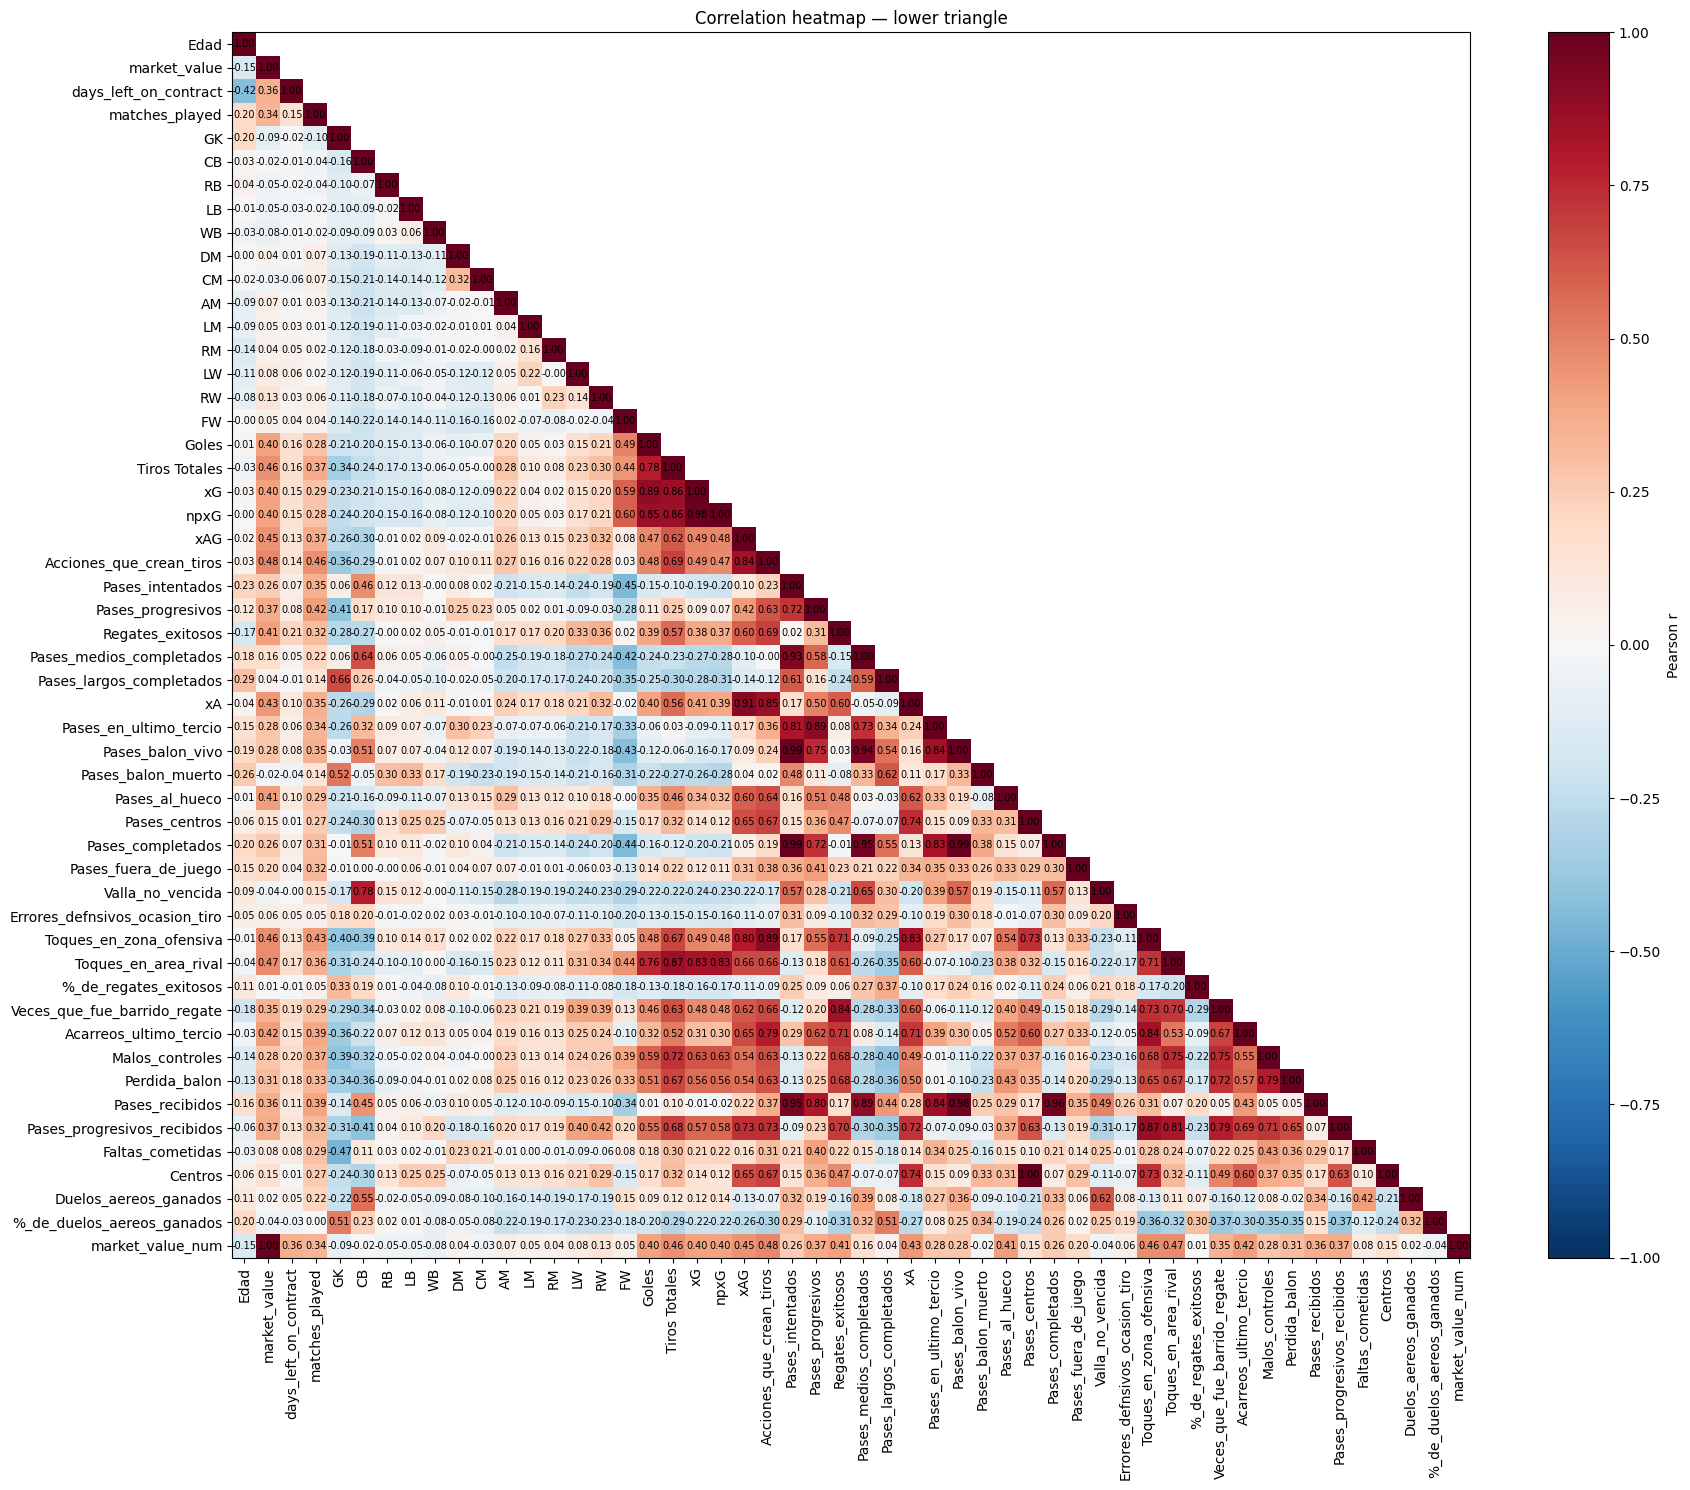

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = players_simple.copy()
df["market_value_num"] = pd.to_numeric(df["market_value"], errors="coerce")

num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)

vals = corr.values
# Mask upper triangle (above diagonal)
upper_mask = np.triu(np.ones_like(vals, dtype=bool), k=1)
vals_masked = np.ma.array(vals, mask=upper_mask)

fig, ax = plt.subplots(figsize=(18, 15))

# Diverging cmap; show masked (upper) cells as white
cmap = plt.cm.RdBu_r.copy()
cmap.set_bad(color="white")

im = ax.imshow(
    vals_masked, cmap=cmap, vmin=-1, vmax=1, aspect="auto", interpolation="nearest"
)
fig.colorbar(im, ax=ax, label="Pearson r")

ax.set_title("Correlation heatmap — lower triangle")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)

# Annotate only lower triangle (i >= j)
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        if i >= j:
            ax.text(j, i, f"{vals[i, j]:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()

In [71]:
print(corr.to_string())

                                    Edad  market_value  days_left_on_contract  matches_played        GK        CB        RB        LB        WB        DM        CM        AM        LM        RM        LW        RW        FW     Goles  Tiros Totales        xG      npxG       xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados        xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas   Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados  market_value_num
Edad                            1.000000     -0.154143              -0.424805        0.203019  

In [72]:
import numpy as np
import pandas as pd

df = players_simple.copy()
df["market_value_num"] = pd.to_numeric(df["market_value"], errors="coerce")

# ----- STEP 0: build the correlation table vs LOG target
num = df.select_dtypes(include=[np.number]).copy()
num["target_log"] = np.log1p(num["market_value_num"])

corr = num.corr(numeric_only=True)
corr_to_target = (
    corr["target_log"]
    .drop(labels=["market_value_num", "target_log"])
    .sort_values(key=np.abs, ascending=False)
)

print("Top correlations with log target:\n", corr_to_target.head(20))

# ----- STEP 1: keep only features with |r| >= threshold (tweak threshold)
thr = 0.15  # start here; raise to be stricter or lower to be more inclusive
candidates = corr_to_target[corr_to_target.abs() >= thr].index.tolist()
print(f"\nCandidates (|r| >= {thr}): {len(candidates)}\n", candidates)


# ----- STEP 2: prune highly collinear features among themselves (greedy)
def greedy_prune(corr_matrix, ordered_features, max_r=0.85):
    selected = []
    for f in ordered_features:  # already ordered by |r with target|
        if all(abs(corr_matrix.loc[f, s]) < max_r for s in selected):
            selected.append(f)
    return selected


corr_sub = num[candidates + ["target_log"]].corr().abs()
selected = greedy_prune(corr_sub, candidates, max_r=0.85)
print(
    f"\nSelected after collinearity prune (|pairwise r| < 0.85): {len(selected)}\n",
    selected,
)

# ----- OPTIONAL: always keep age (we’ll curve it later), even if r is small
force_keep = ["Edad"]
selected_final = list(dict.fromkeys(force_keep + selected))
print("\nFinal feature list (add Edad for Edad_c & Edad_c2 later):\n", selected_final)

Top correlations with log target:
 market_value                   0.814547
matches_played                 0.463609
Acciones_que_crean_tiros       0.461649
Toques_en_area_rival           0.446143
Toques_en_zona_ofensiva        0.442080
Tiros Totales                  0.431804
Pases_recibidos                0.431036
Acarreos_ultimo_tercio         0.416676
days_left_on_contract          0.415502
xAG                            0.414604
Pases_progresivos              0.404537
xA                             0.382303
npxG                           0.376636
Regates_exitosos               0.373853
Goles                          0.368148
xG                             0.367303
Pases_al_hueco                 0.356616
Pases_balon_vivo               0.351781
Pases_progresivos_recibidos    0.345320
Perdida_balon                  0.330288
Name: target_log, dtype: float64

Candidates (|r| >= 0.15): 29
 ['market_value', 'matches_played', 'Acciones_que_crean_tiros', 'Toques_en_area_rival', 'Toques_en_zon

## 2.9 Construcción de dataset limpio

In [73]:
import numpy as np
import pandas as pd

# Punto de partida
df = players_simple.copy()  # <- ya es 1 fila por jugador
df["market_value_num"] = pd.to_numeric(df["market_value"], errors="coerce")
df["target_log"] = np.log1p(df["market_value_num"])

# --- 1) Features de edad (centrado + cuadrado) ---
age = df["Edad"].astype(float)
age_filled = age.fillna(age.median())  # 2 faltantes según tu chequeo
mu_age = age_filled.mean()
df["Edad_c"] = age_filled - mu_age
df["Edad_c2"] = df["Edad_c"] ** 2

# --- 2) Verifica que 'selected_final' exista y esté en las columnas ---
try:
    selected_final
except NameError:
    raise RuntimeError(
        "No encuentro 'selected_final'. Ejecuta antes la celda del selector por correlación."
    )

missing = [c for c in selected_final if c not in df.columns]
if missing:
    raise RuntimeError(
        f"Estas columnas de 'selected_final' no están en players_simple: {missing}"
    )

# Si 'Edad' estaba en selected_final, la sustituimos por Edad_c y Edad_c2
base_feats = [c for c in selected_final if c != "Edad"]

# --- 3) (Opcional) Añadir posiciones; pon False si no quieres usarlas ---
USE_POS = True
pos_feats = ["GK", "CB", "WB", "LW", "RW", "FW"] if USE_POS else []

# --- 4) Armar matriz de modelado (X + y) ---
model_cols = base_feats + ["Edad_c", "Edad_c2"] + pos_feats
keep_cols = model_cols + ["market_value_num", "target_log"]

model_df = df[keep_cols].copy()

# Elimina filas con NA en X o y
model_df = model_df.dropna(subset=model_cols + ["market_value_num"]).copy()

# Anexa identificadores y algunos metadatos útiles
model_df = (
    model_df.join(df[["Nacionalidad"]], how="left")
    .reset_index()  # Jugador pasa a columna
    .rename(columns={"index": "Jugador"})
)

# Hay 2 filas con 'Nacionalidad' nula. Dado que es un número muy pequeño, las eliminamos.
model_df.dropna(subset=['Nacionalidad'], inplace=True)

print("Matriz de modelado:", model_df.shape)
print("NAs por columna (deberían ser 0):")
print(
    model_df[model_cols + ["market_value_num"]]
    .isna()
    .sum()
    .sort_values(ascending=False)
    .head()
)

# --- 5) Dataset completo “limpio” (para referencia) ---
full_df = df.copy().reset_index().rename(columns={"index": "Jugador"})

# --- 6) Exportar a CSV ---
model_path = "players_model_matrix.csv"
full_path = "players_clean_full.csv"

model_df.to_csv(model_path, index=False, encoding="utf-8")
full_df.to_csv(full_path, index=False, encoding="utf-8")

print(
    f"\nGuardado:\n- {model_path}  (para entrenar)\n- {full_path}   (completo, exploración)"
)

Matriz de modelado: (1500, 30)
NAs por columna (deberían ser 0):
market_value                0
matches_played              0
Acciones_que_crean_tiros    0
Toques_en_area_rival        0
Pases_recibidos             0
dtype: int64

Guardado:
- players_model_matrix.csv  (para entrenar)
- players_clean_full.csv   (completo, exploración)


## 3.1 Creación del modelo

El proceso de modelado comienza con la carga del conjunto de datos ya procesado y agregado, `players_model_matrix.csv`.

La variable objetivo (`y`) se establece como `target_log`, que corresponde al valor de mercado transformado logarítmicamente. Esta transformación sirve para mitigar la asimetría presente en los valores de mercado, necesario para mejorar el rendimiento de los modelos lineales. Por otro lado, las variables explicativas (`X`) se conforman con el resto de las características disponibles, como estadísticas de rendimiento, edad y variables de posición, excluyendo únicamente los identificadores de jugador y la propia variable objetivo.

Finalmente, para asegurar una evaluación objetiva del rendimiento del modelo, el conjunto de datos se divide en dos subconjuntos: un 80% de los datos se destina al entrenamiento del modelo y el 20% restante se reserva como conjunto de prueba. Este último conjunto no será utilizado durante la fase de entrenamiento y servirá exclusivamente para medir la capacidad del modelo para generalizar sobre datos nuevos.

In [74]:
from sklearn.model_selection import train_test_split

model_df = pd.read_csv('players_model_matrix.csv')


print(f"Tamaño del DataFrame después de eliminar nulos: {model_df.shape}")

# Variable objetivo
y = model_df['target_log']

# Excluimos todas las columnas relacionadas con el target y el identificador del jugador.
# Variables explicativas
X = model_df.drop(columns=['Jugador', 'market_value', 'market_value_num', 'target_log'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Dimensiones de los Datos ---")
print("Forma de X (features):", X.shape)
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)

Tamaño del DataFrame después de eliminar nulos: (1500, 30)

--- Dimensiones de los Datos ---
Forma de X (features): (1500, 26)
Forma de X_train: (1200, 26)
Forma de X_test: (300, 26)


## 3.2 Transformaciones de las variables numéricas y categóricas usando un pipeline

Para automatizar el preprocesamiento de los datos y asegurar la consistencia tanto en el entrenamiento como en la predicción, se construyó un `Pipeline` utilizando Scikit-learn. Este pipeline integra todas las transformaciones necesarias antes de alimentar los datos al modelo.

Dentro del pipeline, se utiliza un `ColumnTransformer`. A todas las características numéricas se les aplica un `StandardScaler`, que estandariza sus valores eliminando la media y escalando a una varianza unitaria. Este paso sirve para que el modelo pondere adecuadamente cada variable sin ser influenciado por sus diferentes escalas. Para las variables categóricas, como `Nacionalidad`, se emplea un `OneHotEncoder`. Esta técnica convierte cada categoría en una nueva columna binaria, permitiendo que el modelo interprete la nacionalidad como una característica sin darle un orden.

Finalmente, el `Pipeline` integra este preprocesador con el modelo de regresión. Se optó por un modelo de **Regresión Ridge**, una variante regularizada de la regresión lineal que ofrece mayor robustez frente a la multicolinealidad entre variables y ayuda a prevenir el sobreajuste (que el modelo se sepa las respuestas de memoria).

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numericas = X_train.select_dtypes(include=np.number).columns.tolist()
categoricas = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numéricas a escalar:", numericas)
print("Variables categóricas a codificar:", categoricas)

preprocessor = ColumnTransformer(
    transformers=[
        # Transformación para datos numéricos
        ('num', StandardScaler(), numericas),
        
        # Transformación para variables categóricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas)
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])


Variables numéricas a escalar: ['matches_played', 'Acciones_que_crean_tiros', 'Toques_en_area_rival', 'Pases_recibidos', 'Acarreos_ultimo_tercio', 'days_left_on_contract', 'xAG', 'Pases_progresivos', 'npxG', 'Regates_exitosos', 'Pases_al_hueco', 'Pases_progresivos_recibidos', 'Perdida_balon', 'Veces_que_fue_barrido_regate', 'Malos_controles', 'Pases_fuera_de_juego', 'Faltas_cometidas', 'Edad_c', 'Edad_c2', 'GK', 'CB', 'WB', 'LW', 'RW', 'FW']
Variables categóricas a codificar: ['Nacionalidad']


In [76]:
# Entrenamiento del modelo
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [77]:
pipeline["model"].intercept_

np.float64(2.166614154509538)

In [78]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

coefficients = pipeline.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values('abs_coefficient', ascending=False).drop(columns='abs_coefficient')

print(coef_df_sorted.to_string())

                                                feature  coefficient
57                              cat__Nacionalidad_Gabon    -0.702106
77                         cat__Nacionalidad_Martinique    -0.668627
33                             cat__Nacionalidad_Brazil     0.648783
94                             cat__Nacionalidad_Russia     0.587592
108                            cat__Nacionalidad_Turkey     0.510578
63                             cat__Nacionalidad_Guinea    -0.509925
38                         cat__Nacionalidad_Cape Verde    -0.497345
27                             cat__Nacionalidad_Angola    -0.470228
52                            cat__Nacionalidad_England     0.461762
50                            cat__Nacionalidad_Ecuador     0.456196
71                            cat__Nacionalidad_Jamaica     0.454901
44                             cat__Nacionalidad_Cyprus    -0.452151
69                            cat__Nacionalidad_Ireland     0.423509
53                  cat__Nacionali

In [83]:
y_pred_log = pipeline.predict(X_test)
y_pred_log

array([ 4.65990106,  2.92336262,  1.57076022,  2.02339307,  3.31488972,
        1.86855314,  2.95597396,  4.12743039,  0.75855901,  1.63572184,
        0.88798522,  2.97471635,  3.16340948,  2.49264253,  1.8542585 ,
        4.02574911,  1.03484787,  0.71623318,  2.63991322,  1.99931085,
        2.08381999,  3.69449062,  4.74988755,  2.97665572,  3.97161778,
        2.44357275,  3.2391038 ,  2.38227322,  2.2385025 ,  0.70266935,
        1.58373929,  1.69856298,  3.58911134,  1.10423671,  2.49376989,
        1.62097743,  1.34595535,  2.33989181,  3.5635137 ,  2.25009413,
        2.32582982,  2.57674385,  1.64991109,  1.95895818,  1.76614628,
        2.54559685,  2.59027744,  3.37615513,  2.36474529,  2.97631326,
        2.32332501,  2.29518165,  0.71797927,  3.24280002,  1.80013843,
        1.47070065,  2.65234848,  2.41449945,  2.45741218,  2.5290745 ,
        1.29925568,  3.04163691,  1.94626607,  2.95998834,  2.06444295,
        1.20685149,  1.83448046,  3.62287424,  2.23587904,  2.77

## 3.3 Cálculo de métricas de calidad del modelo

Una vez entrenado el pipeline y realizadas las predicciones, se procede a la evaluación cuantitativa del modelo. El primer paso consiste en revertir tanto los valores predichos como los valores reales del conjunto de prueba desde su escala logarítmica a su escala original en euros. Esta transformación, realizada con la función `np.expm1`.

Con los valores ya en euros, se calculan varias métricas de rendimiento. El **R-cuadrado (R²)** se utiliza para medir la proporción de la varianza en el valor de mercado que es explicada por el modelo. Para cuantificar el error, se calculan el **Error Absoluto Medio (MAE)**, que representa la magnitud promedio del error en millones de euros, y la **Raíz del Error Cuadrático Medio (RMSE)**, que también mide el error pero penaliza en mayor medida las desviaciones grandes. Adicionalmente, se calcula un **Error Porcentual (MAPE)** para contextualizar la magnitud del error en relación con el valor promedio de los jugadores.

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred_euros = np.expm1(y_pred_log)
y_test_euros = np.expm1(y_test)

# Calculamos las métricas de error usando los valores en euros
r2 = r2_score(y_test_euros, y_pred_euros)
mae = mean_absolute_error(y_test_euros, y_pred_euros)
media = np.mean(np.abs(y_test_euros))
mape = (mae / media) * 100
rmse = np.sqrt(mean_squared_error(y_test_euros, y_pred_euros))

print(f"\n--- Resultados de la Evaluación (en millones de Euros) ---")
print(f"R²: {r2:.4f}")
print(f"MAE (Error Absoluto): {mae:.2f} millones de €")
print(f"MAPE (Error Porcentual): {mape:.2f} %")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f} millones de €")


--- Resultados de la Evaluación (en millones de Euros) ---
R²: 0.5440
MAE (Error Absoluto): 8.39 millones de €
MAPE (Error Porcentual): 50.56 %
RMSE (Raíz del Error Cuadrático Medio): 16.06 millones de €


R²=0.5440 | MAE=8.39 M€ | RMSE=16.06 M€ | MAPE-like=50.56% | MAPE=106.94%


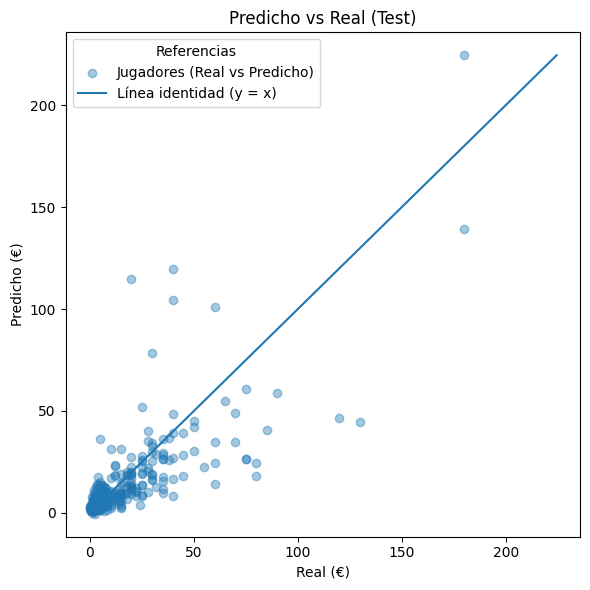

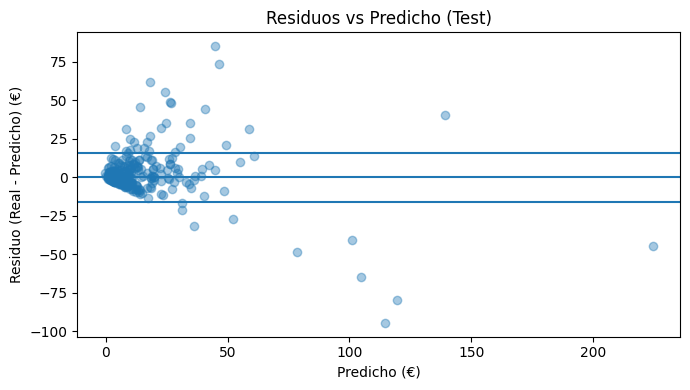

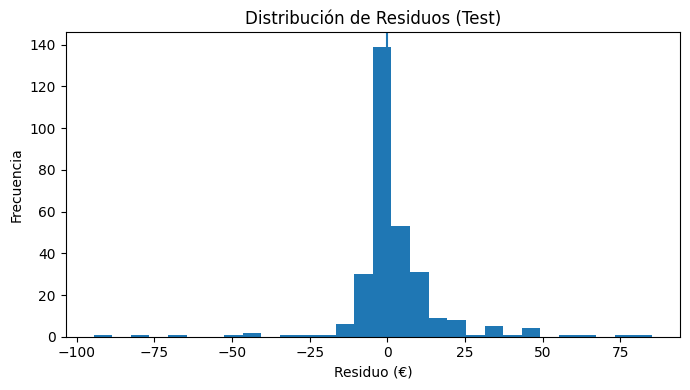

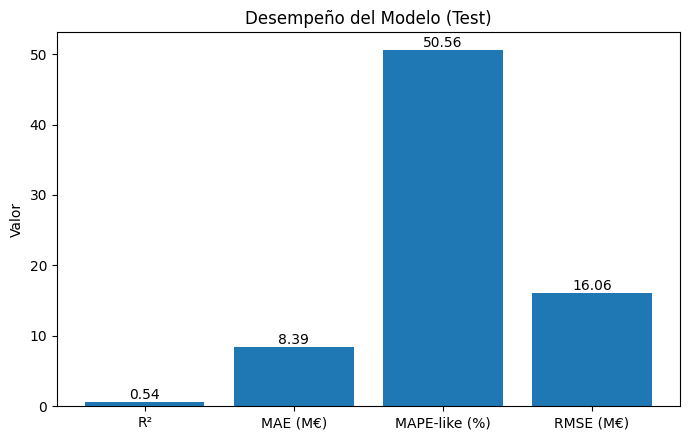

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Recalcular métricas en euros (dinámico) ---
y_pred_euros = np.expm1(y_pred_log)
y_test_euros = np.expm1(y_test)

r2 = r2_score(y_test_euros, y_pred_euros)
mae = mean_absolute_error(y_test_euros, y_pred_euros)
rmse = np.sqrt(((y_test_euros - y_pred_euros) ** 2).mean())

# "MAPE" que venías usando (MAE / media |y|)
mape_like = (mae / np.mean(np.abs(y_test_euros))) * 100

# MAPE clásico (cuidado: sensible a valores pequeños/cero)
eps = 1e-9
mape_true = (
    np.mean(
        np.abs((y_test_euros - y_pred_euros) / np.clip(np.abs(y_test_euros), eps, None))
    )
    * 100
)

print(
    f"R²={r2:.4f} | MAE={mae:.2f} M€ | RMSE={rmse:.2f} M€ | MAPE-like={mape_like:.2f}% | MAPE={mape_true:.2f}%"
)

# --- 2) Predicho vs Real (€) ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test_euros, y_pred_euros, alpha=0.4, label="Jugadores (Real vs Predicho)")
lo = float(min(y_test_euros.min(), y_pred_euros.min()))
hi = float(max(y_test_euros.max(), y_pred_euros.max()))
plt.plot([lo, hi], [lo, hi], label="Línea identidad (y = x)")  # línea identidad

plt.xlabel("Real (€)")
plt.ylabel("Predicho (€)")
plt.title("Predicho vs Real (Test)")
plt.legend(title="Referencias")  # ← etiquetas en la figura
plt.tight_layout()
plt.savefig("pred_vs_real.png", dpi=180)
plt.show()


# --- 3) Residuos vs Predicho (€) con bandas ±RMSE ---
res = y_test_euros - y_pred_euros
plt.figure(figsize=(7, 4))
plt.scatter(y_pred_euros, res, alpha=0.4)
plt.axhline(0)
plt.axhline(rmse)
plt.axhline(-rmse)
plt.xlabel("Predicho (€)")
plt.ylabel("Residuo (Real - Predicho) (€)")
plt.title("Residuos vs Predicho (Test)")
plt.tight_layout()
plt.savefig("residuals_vs_pred.png", dpi=180)
plt.show()

# --- 4) Histograma de residuos (€) ---
plt.figure(figsize=(7, 4))
plt.hist(res, bins=30)
plt.axvline(0)
plt.xlabel("Residuo (€)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos (Test)")
plt.tight_layout()
plt.savefig("residuals_hist.png", dpi=180)
plt.show()

# --- 5) Gráfico de métricas (dinámico, sin hardcode) ---
labels = ["R²", "MAE (M€)", "MAPE-like (%)", "RMSE (M€)"]
values = [r2, mae, mape_like, rmse]

plt.figure(figsize=(7, 4.5))
plt.bar(labels, values)
for i, v in enumerate(values):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.title("Desempeño del Modelo (Test)")
plt.ylabel("Valor")
plt.tight_layout()
plt.savefig("metrics_bar_chart.png", dpi=180)
plt.show()

## 3.4 Pipeline exportado en formato .joblib

Se exporta el pipeline creado al formato solicitado y además se hace una prueba del correcto funcionamiento de este haciendo la predicción para el primer jugador de los datos de prueba.

In [81]:
import joblib

filename = 'futalpes_regression_model.joblib'

joblib.dump(pipeline, filename)

print("Modelo exportado y guardado exitosamente")

loaded_model = joblib.load(filename)
print("Modelo cargado exitosamente desde el archivo.")

jugador = X_test.iloc[[0]]

prediction_log = loaded_model.predict(jugador)
prediction_euros = np.expm1(prediction_log)

print(f"\nPredicción de prueba con el modelo cargado para un jugador de muestra:")
print(f"Valor predicho: {prediction_euros[0]:,.2f} millones de €")

Modelo exportado y guardado exitosamente
Modelo cargado exitosamente desde el archivo.

Predicción de prueba con el modelo cargado para un jugador de muestra:
Valor predicho: 104.63 millones de €
